In [1]:
import pygame
import numpy as np
import gym
from gym import spaces
import time
class MazeEnv(gym.Env):
    def __init__(self, maze, screen,ep):
        super(MazeEnv, self).__init__()
        self.maze = maze
        self.rows, self.cols = maze.shape
        self.robot_position = (0, 0)
        self.exit_position = (self.rows - 1, self.cols - 1)
        self.screen = screen
        self.score = 0  # Initialize score counter
        self.path_taken = []  # To store the path taken during exploration

        self.action_space = spaces.Discrete(8)  # Corrected action space
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.rows),
            spaces.Discrete(self.cols)
        ))

        # Define rewards
        self.passive_reward = -1
        self.exit_reward = 100
        self.collision_penalty = -10

        # Q-learning parameters
        self.epsilon = ep
        self.gamma = 0.5
        self.q_table = np.zeros((self.rows, self.cols, self.action_space.n))
        self.alpha = 0.05

        self.reset()

    def reset(self):
        self.robot_position = (0, 0)
        self.score = 0  # Reset score to 0
        self.path_taken = []  # Reset path taken
        return self.robot_position

    def step(self, action):
        row, col = self.robot_position
        if action == 0:  # move up
            row -= 1
        elif action == 1:  # move down
            row += 1
        elif action == 2:  # move left
            col -= 1
        elif action == 3:  # move right
            col += 1
        elif action == 4:  # move up-left
            row -= 1
            col -= 1
        elif action == 5:  # move up-right
            row -= 1
            col += 1
        elif action == 6:  # move down-left
            row += 1
            col -= 1
        elif action == 7:  # move down-right
            row += 1
            col += 1

        # Ensure the robot stays within the maze
        row = max(0, min(row, self.rows - 1))
        col = max(0, min(col, self.cols - 1))

        # Check if the new position is a wall
        if self.maze[row][col] == 1:
            reward = self.collision_penalty
        else:
            self.robot_position = (row, col)
            if self.robot_position == self.exit_position:
                reward = self.exit_reward  # Reached the exit
            else:
                reward = self.passive_reward  # Moved to a valid position

        # Update score
        self.score += reward

        # Update path taken
        self.path_taken.append(self.robot_position)

        # Update Q-table
        old_q_value = self.q_table[self.robot_position[0], self.robot_position[1], action]
        max_future_q = np.max(self.q_table[self.robot_position[0], self.robot_position[1]])
        new_q_value = (1 - self.alpha) * old_q_value + self.alpha * (reward + self.gamma * max_future_q)
        self.q_table[self.robot_position[0], self.robot_position[1], action] = new_q_value

        done = self.robot_position == self.exit_position
        return self.robot_position, reward, done, {'score': self.score}  # Return score in the info dict

    def choose_action(self):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.action_space.n)  # Choose random action
        else:
            return np.argmax(self.q_table[self.robot_position[0], self.robot_position[1]])  # Choose best action

    def get_path_taken(self):
        return self.path_taken

    def render(self):
        cell_width = 30
        cell_height = 30

        # Load images
        robot_image = pygame.image.load("robot.png")
        robot_image = pygame.transform.scale(robot_image, (cell_width, cell_height))
        exit_image = pygame.image.load("exit.png")
        exit_image = pygame.transform.scale(exit_image, (cell_width, cell_height))

        # Draw maze walls and paths
        for row in range(self.rows):
            for col in range(self.cols):
                if self.maze[row][col] == 1:
                    pygame.draw.rect(self.screen, (0, 0, 255), (col * cell_width, row * cell_height, cell_width, cell_height))  # Blue block for walls
                else:
                    if (row, col) == self.robot_position:
                        pygame.draw.rect(self.screen, (0, 255, 0), (col * cell_width, row * cell_height, cell_width, cell_height))  # Green block for robot position
                    else:
                        pygame.draw.rect(self.screen, (255, 255, 255), (col * cell_width, row * cell_height, cell_width, cell_height))  # White block for paths

        # Draw robot and exit positions
        self.screen.blit(robot_image, (self.robot_position[1] * cell_width, self.robot_position[0] * cell_height))  # Robot
        self.screen.blit(exit_image, (self.exit_position[1] * cell_width, self.exit_position[0] * cell_height))  # Exit

        # Render score text
        font = pygame.font.SysFont(None, 25)
        score_text = font.render(f'Score: {self.score}', True, (255, 255, 255))
        self.screen.blit(score_text, (10, self.rows * cell_height + 10))  # Adjusted position for score text

        pygame.display.flip()
def main(rows, cols,ep):
    maze_layout = np.zeros((rows, cols))

    start_row, start_col = 0, 1
    exit_row, exit_col = rows - 1, cols - 2
    maze_layout[start_row, start_col] = 0  # Starting position
    maze_layout[exit_row, exit_col] = 0  # Exit position

    # Add random walls
    num_walls = int(0.1 * (rows * cols))  #wall density : to 20% of total cells
    for _ in range(num_walls):
        row, col = np.random.randint(1, rows - 1), np.random.randint(1, cols - 1)
        maze_layout[row, col] = 1  # Set cell to be a wall

    # Initialize Pygame
    pygame.init()
    pygame.display.set_caption("Maze Game") 
    screen = pygame.display.set_mode((cols * 30, rows * 30))

    env = MazeEnv(maze_layout, screen, ep)  

    start_time = time.time()



    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        action = env.choose_action()  # Choose action based on ε-greedy policy
        observation, reward, done, info = env.step(action)
        env.render()
        pygame.time.wait(1)  # Delay for visualization

        if done:  # Exit the main loop if done
            running = False

    end_time = time.time()
    elapsed_time = end_time - start_time
    pygame.quit()

    print("Elapsed time:", elapsed_time, "seconds")

    path_taken = env.get_path_taken()
    print("Number of cycles:", len(path_taken))

    return len(path_taken), elapsed_time


if __name__ == "__main__":
    maze_size = (7, 7)
    eps = [0.9,0.5,0.4,0.3]
    results = {}

    for ep in eps:
        print(f"Testing epsilon: {ep}")
        cycles, time_spent = main(*maze_size, ep)
        results[ep] = (cycles, time_spent)

    print("\nResults:")
    for epsilon, result in results.items():
        print(f"epsilon: {epsilon}, Maze size {maze_size}: Cycles={result[0]}, Time={result[1]} seconds")



pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
Testing epsilon: 0.9
Elapsed time: 8.437779188156128 seconds
Number of cycles: 378
Testing epsilon: 0.5
Elapsed time: 4.861093282699585 seconds
Number of cycles: 330
Testing epsilon: 0.4
Elapsed time: 86.06806540489197 seconds
Number of cycles: 5737
Testing epsilon: 0.3
Elapsed time: 165.60106587409973 seconds
Number of cycles: 11190

Results:
epsilon: 0.9, Maze size (7, 7): Cycles=378, Time=8.437779188156128 seconds
epsilon: 0.5, Maze size (7, 7): Cycles=330, Time=4.861093282699585 seconds
epsilon: 0.4, Maze size (7, 7): Cycles=5737, Time=86.06806540489197 seconds
epsilon: 0.3, Maze size (7, 7): Cycles=11190, Time=165.60106587409973 seconds


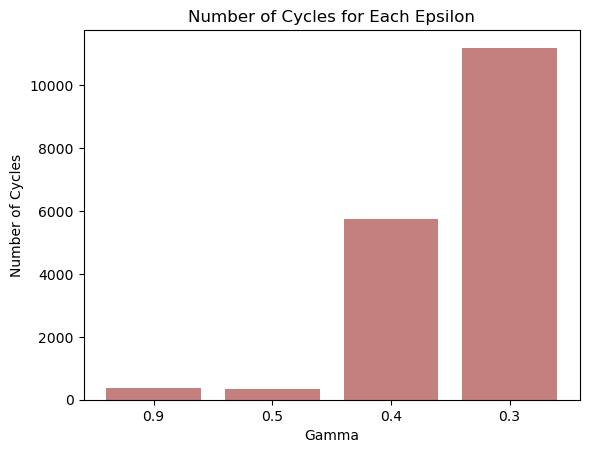

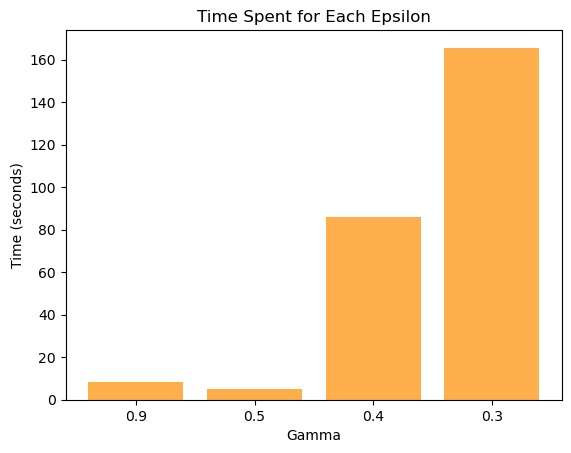

In [2]:
import matplotlib.pyplot as plt
cycles_data = [result[0] for ep, result in results.items()]
time_data = [result[1] for ep, result in results.items()]

plt.bar(range(len(eps)), cycles_data, align='center', alpha=0.5,color='darkred')
plt.xticks(range(len(eps)), eps)
plt.xlabel('Gamma')
plt.ylabel('Number of Cycles')
plt.title('Number of Cycles for Each Epsilon')
plt.show()

plt.bar(range(len(eps)), time_data, align='center', alpha=0.7, color='darkorange')
plt.xticks(range(len(eps)), eps)
plt.xlabel('Gamma')
plt.ylabel('Time (seconds)')
plt.title('Time Spent for Each Epsilon')
plt.show()
